# Report on Fourier spectral analysis


This notebook takes as input two synthetic datasets: one for the "basic" and other for the "soil" baselines.
For these two datasets, we perform the following steps:
- calculate fourier transform (FT)
- fiter out the amplitudes of the FT corresponding to the equivalent frequency of a 1 year period & its corresponding harmonics (i.e. 1/2 year, 1/4 year, ....) in order to remove the 1 year seasonality
- inverse FT the filtered power spectrum

**Achievements**
- (Partially) remove the seasonality of the basic and soil datasets

**To do/open questions**
- Is there an improvement if we remove the spectral power corresponding to a 2 years frequency?
- Redo all for power signal downsampled to hourly frequncy

**Some comments**

In general, Fourier decomposition (FD) methods apply for linear & stationary time-series data. 
However see [here](https://royalsocietypublishing.org/doi/10.1098/rspa.2016.0871) for a generalization of a FD method that applies for non-linear & non-stationary problems.

In [12]:
# In the root of the repo run "pip install --editable ."

# OPTIONAL: Load the "autoreload" extension so that code can change
%load_ext autoreload

# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

# Replace sample_func_dir by the name of directory in src/ and replace sample_func_file the
# file name in src/sample_func_dir

from src.data.import_data import import_df_from_zip_pkl
from src.data.make_dataset import *
from scipy import fftpack
import matplotlib.pyplot as plt
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# Load data 
csv_index   = 2
synth_name  = "basic"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_basic    = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)
synth_name  = "soil"
path_to_zip = "../data/raw/synthetic_" + synth_name + ".zip"
df_soil     = import_df_from_zip_pkl(path_to_zip, index=csv_index, verbose=True)

time for importing dataframe: 0.61 seconds
time for importing dataframe: 0.71 seconds


In [14]:
# Preprocess data : remove night & clipping + downsampling to daily frequency
df_basic = downsample_dataframe(df_basic, night_method='basic', clip_method='universal')
df_soil  = downsample_dataframe(df_soil, night_method='basic', clip_method='universal')

(229172, 8)
(147624, 8)


In [15]:
df_basic.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [16]:
df_soil.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2015-01-01 00:00:00-05:00 to 2019-12-31 00:00:00-05:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Power          1826 non-null   float64
 1   POA            1826 non-null   float64
 2   Tamb           1826 non-null   float64
 3   Wind           1826 non-null   float64
 4   Degradation    1826 non-null   float64
 5   Soiling        1826 non-null   float64
 6   Faults         1826 non-null   float64
 7   minute_of_day  1826 non-null   float64
dtypes: float64(8)
memory usage: 128.4 KB


In [17]:
df_basic.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,373.200000,167.904000,7.360400,0.0,0.999985,1.0,1.0,759.612000
2015-01-02 00:00:00-05:00,378.257028,169.899598,7.328112,0.0,0.999957,1.0,1.0,760.763052
2015-01-03 00:00:00-05:00,380.512000,170.740000,7.291200,0.0,0.999934,1.0,1.0,761.804000
2015-01-04 00:00:00-05:00,383.091633,171.645418,7.250996,0.0,0.999905,1.0,1.0,762.840637
2015-01-05 00:00:00-05:00,385.932540,172.666667,7.217063,0.0,0.999875,1.0,1.0,763.873016


In [8]:
df_basic.tail()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2019-12-27 00:00:00-05:00,756.726606,318.409174,7.707890,0.0,0.950754,1.0,1.0,744.0
2019-12-28 00:00:00-05:00,760.454044,319.893382,7.663051,0.0,0.950727,1.0,1.0,744.5
2019-12-29 00:00:00-05:00,761.744954,320.335780,7.626789,0.0,0.950700,1.0,1.0,745.0
2019-12-30 00:00:00-05:00,763.335165,320.899267,7.581502,0.0,0.950673,1.0,1.0,745.5
2019-12-31 00:00:00-05:00,765.213894,321.590494,7.542230,0.0,0.950660,1.0,1.0,746.0


In [9]:
df_soil.head()

,Power,POA,Tamb,Wind,Degradation,Soiling,Faults,minute_of_day
datetime,,,,,,,,
2015-01-01 00:00:00-05:00,387.678295,173.124031,7.363178,0.0,0.999985,1.0,1.0,758.864341
2015-01-02 00:00:00-05:00,392.774319,175.124514,7.329572,0.0,0.999948,1.0,1.0,759.976654
2015-01-03 00:00:00-05:00,395.046512,175.972868,7.293023,0.0,0.999915,1.0,1.0,760.988372
2015-01-04 00:00:00-05:00,397.637066,176.880309,7.252510,0.0,0.999885,1.0,1.0,761.996139
2015-01-05 00:00:00-05:00,400.515385,177.907692,7.218077,0.0,0.999849,1.0,1.0,763.000000


## Example of FT & filtering

For the FT calculation, we *encapsulate* our signal in a box with a certain length. In the case at hand, we fix the size of the box to be the signal's length (i.e. box_length = 1826 days). 
If the box_length is larger than the signal's length, then the power outside the signal range will be set to zero.

The preprocessed time-series has a daily frequency. Therefore, this is the highest frequency we will have access to. However, the introduction of the box, sets the maximum frequency to be 1/2 day (which corresponds to the [Nyquist frequency](https://en.wikipedia.org/wiki/Nyquist_frequency)). This is why the power spectrum shown in the below right panel is symmetric with respect to zero.

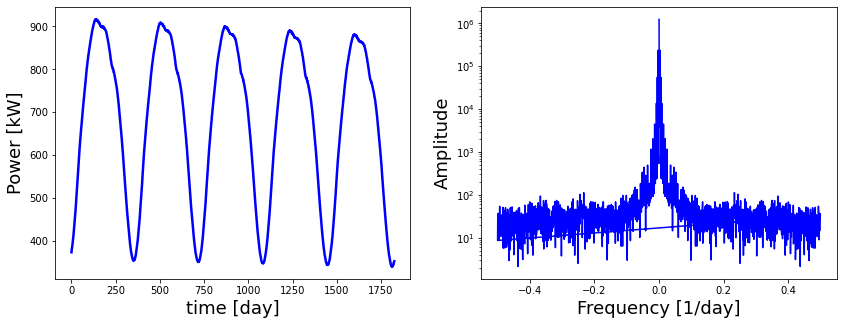

In [22]:
# Manually obtain the frequencies (similar to fftpack.fftfreq)
#L = len(df["Power"].to_numpy()) # length of signal
#T = 1 # [day] # sampling period
#Fs = 1/T # [1/day] # sampling frequency
#freq = Fs*np.arange(L/2)/L
# =========================================================================
box_length  = df_basic["Power"].to_numpy().size
power_fft   = fftpack.fft(df_basic["Power"].to_numpy())
sample_freq = fftpack.fftfreq(box_length, d=1)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue") # plot time series
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)

ax[1].plot(sample_freq, np.abs(power_fft), color="blue") # plot freq domain

ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Frequency [1/day]", fontsize=18)
#ax[1].set_xlim([0, 0.1])
#ax[1].set_xscale("log")
ax[1].set_yscale("log")

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'time [day]')

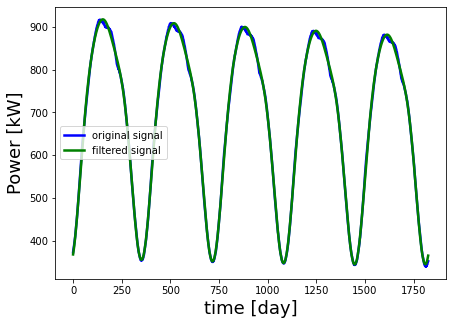

In [25]:
high_freq_fft                             = power_fft.copy()
high_freq_fft[np.abs(sample_freq) > 0.01] = 0 # remove all the hight frequencies
filtered_sig                              = fftpack.ifft(high_freq_fft)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax.plot(filtered_sig, label="filtered signal", lw=2.5, color="green", ls="-")
ax.legend(loc="best")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("time [day]", fontsize=18)

## Plot FT for basic and soiling for (a) daily frequency

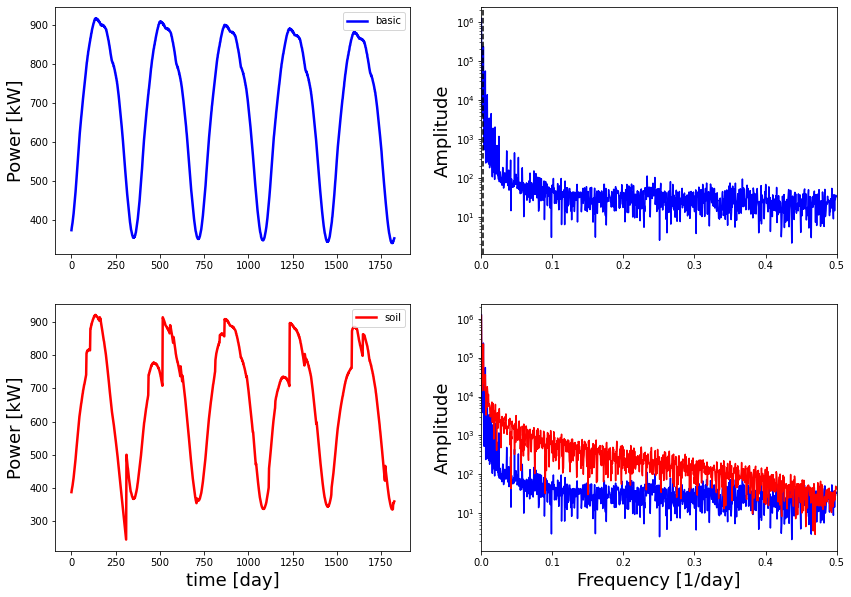

In [29]:
box_length        = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))
ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue", label="basic")
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red", label="soil")
ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)

ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue")
ax[0, 1].axvline(1/365, ls="--", color="k") # this is the year frequency
ax[1, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue")
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red")

ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.5])
ax[1, 1].set_xlim([0, 0.5])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")
ax[0, 0].legend()
ax[1, 0].legend()

**Zoom in different parts of power spectrum x-axis**

- Black dashed vertical lines correspond to 1 year frequency and its harmonics (i.e. 1/2, 1/4, 1/8 year)
- Grey dashed vertical line marks a 2 years frequency
- Dashed blue/red spectrum shows the FT of the signal if the length of the box is twice the size of the signal

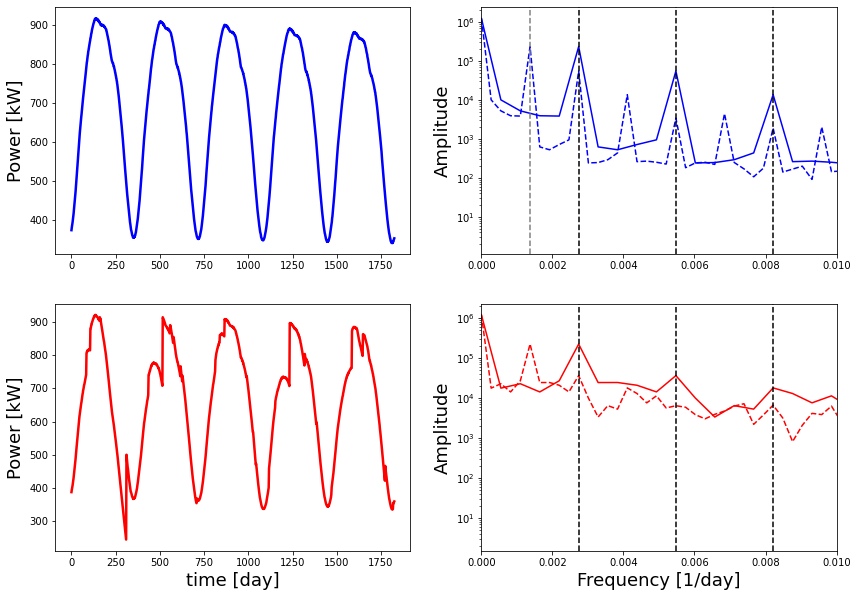

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

box_length        = df_basic["Power"].to_numpy().size*2
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")
ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue", ls="--")
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red", ls="--") 


box_length        = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(size, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue") 
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red")

ax[0, 1].axvline(1./(2*365), color="grey", ls="--")

for i in range(3):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency


ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0, 0.01])
ax[1, 1].set_xlim([0, 0.01])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

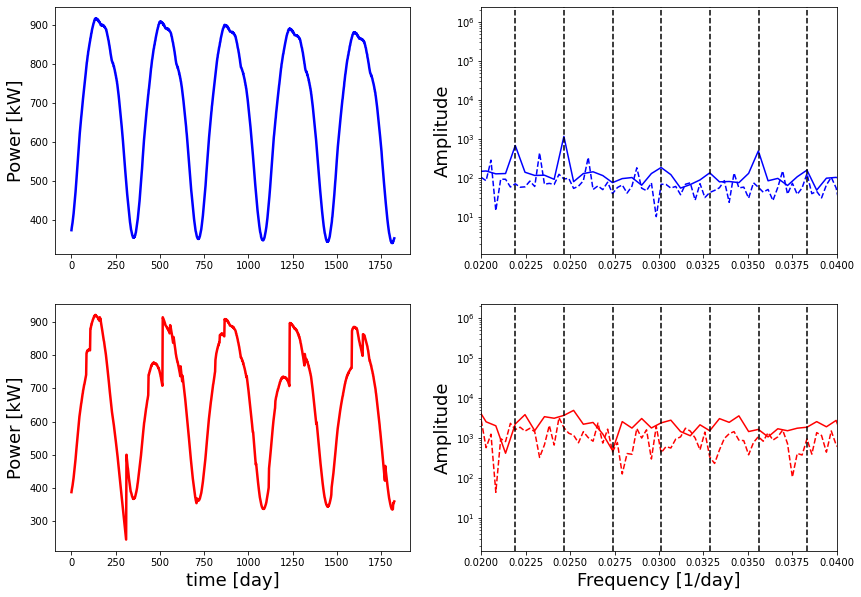

In [32]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

box_length        = df_basic["Power"].to_numpy().size*2
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")
ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue", ls="--")
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red", ls="--")


box_length        = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue") 
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red")

for i in range(15):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.02, 0.04])
ax[1, 1].set_xlim([0.02, 0.04])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

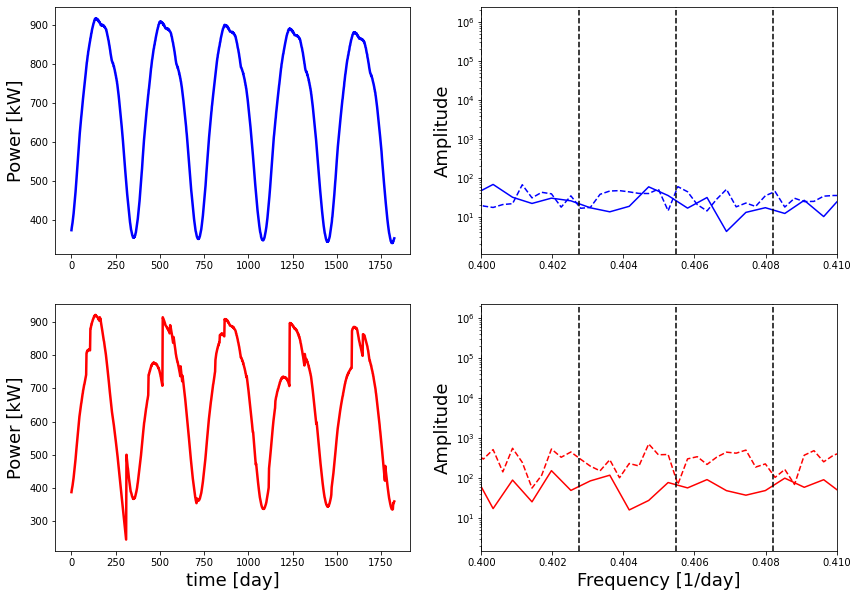

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(14,10))

box_length        = df_basic["Power"].to_numpy().size*2
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 0].plot(df_basic["Power"].to_numpy(), lw=2.5, color="blue")
ax[1, 0].plot(df_soil["Power"].to_numpy(), lw=2.5, color="red")
ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue", ls="--") 
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red", ls="--") 

box_length        = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)

power_soil        = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil  = fftpack.fftfreq(box_length, d=1)

ax[0, 1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue") 
ax[1, 1].plot(sample_freq_soil[0:int(box_length/2)], np.abs(power_soil[0:int(box_length/2)]), color="red")

for i in range(150):
    ax[0, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency
    ax[1, 1].axvline((i+1)/365, ls="--", color="k") # this is the year frequency

ax[0, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_ylabel("Power [kW]", fontsize=18)
ax[1, 0].set_xlabel("time [day]", fontsize=18)
ax[0, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_ylabel("Amplitude", fontsize=18)
ax[1, 1].set_xlabel("Frequency [1/day]", fontsize=18)
ax[0, 1].set_xlim([0.4, 0.41])
ax[1, 1].set_xlim([0.4, 0.41])
ax[0, 1].set_yscale("log")
ax[1, 1].set_yscale("log")

## Filter out + inverse FT

Mask frequency 1/365 (1/days) and its corresponding harmonics (i.e. 1/4, 1/8, ... year)

### Basic signal

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(0.0, 0.04)

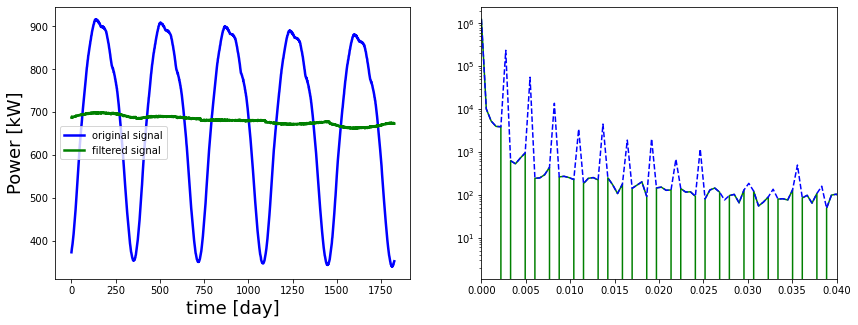

In [35]:
box_length        = df_basic["Power"].to_numpy().size
power_basic       = fftpack.fft(df_basic["Power"].to_numpy(), size)
sample_freq_basic = fftpack.fftfreq(box_length, d=1)


fig, ax = plt.subplots(1, 2, figsize=(14, 5))

high_freq_basic      = power_basic.copy()
pos                  = np.arange(5, 1000, 5)
high_freq_basic[pos] = 0
pos                  = -pos[::-1] # reverse array & make it negative
high_freq_basic[pos] = 0
filtered_sig         = fftpack.ifft(high_freq_basic)

ax[0].plot(df_basic["Power"].to_numpy(), label="original signal", lw=2.5, color="blue")
ax[0].plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")

ax[1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(high_freq_basic[0:int(box_length/2)]), color="green")
ax[1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="blue", ls="--") 

ax[0].legend(loc="best")
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)
ax[1].set_yscale("log")
ax[1].set_xlim([0, 0.04])

**Plot filtered time-series & original yearly power**

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


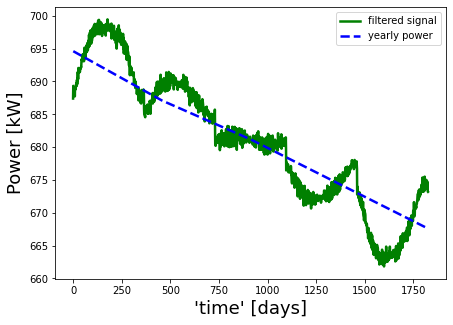

In [37]:
fig, ax = plt.subplots(figsize=(7, 5))

power_year = df_basic.resample("y").mean().Power.to_numpy()
x_year     = np.linspace(1, 1826, 5) # just intended to have same axis as filtered signal

ax.plot(fftpack.ifft(high_freq_basic), label="filtered signal", lw=2.5, color="green")
ax.plot(x_year, power_year, color="blue", ls="--", lw=2.5, label="yearly power")
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("'time' [days]", fontsize=18)
ax.legend()

- Do we reduce the seasonality further if we assume that the box is double the size of the signal and we remove the amplitude for a 2 year frequency? 

### Soil signal

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, 'Frequency [1/day]')

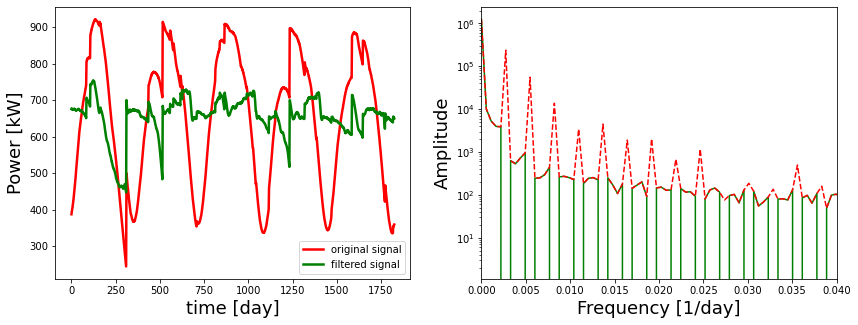

In [38]:
box_length       = df_soil["Power"].to_numpy().size
power_soil       = fftpack.fft(df_soil["Power"].to_numpy(), size)
sample_freq_soil = fftpack.fftfreq(size, d=1)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

high_freq_soil      = power_soil.copy()
pos                 = np.arange(5, 100, 5)
high_freq_soil[pos] = 0
pos                 = -pos[::-1] # reverse array & make it negative
high_freq_soil[pos] = 0
filtered_sig        = fftpack.ifft(high_freq_soil)

ax[0].plot(df_soil["Power"].to_numpy(), label="original signal", lw=2.5, color="red")
ax[0].plot(fftpack.ifft(high_freq_soil), label="filtered signal", lw=2.5, color="green")

ax[1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(high_freq_basic[0:int(box_length/2)]), color="green")
ax[1].plot(sample_freq_basic[0:int(box_length/2)], np.abs(power_basic[0:int(box_length/2)]), color="red", ls="--")

ax[0].legend(loc="best")
ax[0].set_ylabel("Power [kW]", fontsize=18)
ax[0].set_xlabel("time [day]", fontsize=18)
ax[1].set_yscale("log")
ax[1].set_xlim([0, 0.04])
ax[1].set_ylabel("Amplitude", fontsize=18)
ax[1].set_xlabel("Frequency [1/day]", fontsize=18)

**Plot filtered time-series & original yearly power**

/home/maria/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 0, "'time' [days]")

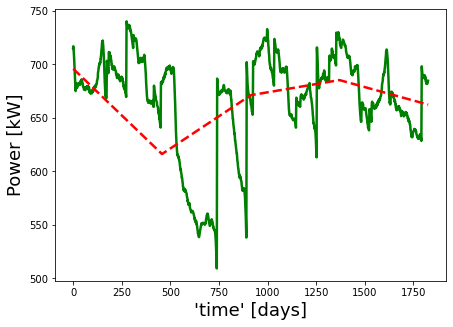

In [85]:
fig, ax = plt.subplots(figsize=(7, 5))

power_year = df_soil.resample("y").mean().Power.to_numpy()
x_year     = np.linspace(1, 1826, 5)

ax.plot(fftpack.ifft(high_freq_soil), label="filtered signal", lw=2.5, color="green")
ax.plot(x_year, power_year, color="red", ls="--", lw=2.5)
ax.set_ylabel("Power [kW]", fontsize=18)
ax.set_xlabel("'time' [days]", fontsize=18)

### Plot FT for basic and soiling for (a) hourly frequency